# Notebook 03: ML Model Training
**Project:** Synthetic Sleep Environment Dataset Generator  
**Authors:** Rushav Dash & Lisa Li  
**Course:** TECHIN 513 — Signal Processing & Machine Learning  
**University:** University of Washington  
**Date:** 2026-02-19

## Table of Contents
1. [Setup & Data Loading](#section-1)
2. [EDA of Sleep Efficiency Dataset](#section-2)
3. [Feature Engineering](#section-3)
4. [Model Training & Cross-validation](#section-4)
5. [Feature Importance Plots](#section-5)
6. [Residual Analysis](#section-6)
7. [Save Models](#section-7)

---
## 1. Setup & Data Loading <a id='section-1'></a>
We import the `SleepQualityModel` class, load the Sleep Efficiency dataset, and configure plotting defaults.

In [1]:
import sys
import os
import warnings
warnings.filterwarnings('ignore')

PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_absolute_error, r2_score

from src.data_loader import DataLoader
from src.sleep_quality_model import SleepQualityModel, _encode_categoricals, _engineer_proxy_features

%matplotlib inline
plt.rcParams.update({'figure.dpi': 120, 'font.size': 11})
sns.set_theme(style='whitegrid')

MODELS_DIR = os.path.join(PROJECT_ROOT, 'data', 'processed', 'models')
os.makedirs(MODELS_DIR, exist_ok=True)

print('Setup complete.')

Setup complete.


In [2]:
loader = DataLoader()
loader.download_all()
df_sleep = loader.load_sleep_efficiency()

print(f'Sleep Efficiency dataset shape: {df_sleep.shape}')
df_sleep.head()

[DataLoader] Downloading Sleep Efficiency dataset…


[DataLoader]   Sleep Efficiency CSV: /home/rushav/.cache/kagglehub/datasets/equilibriumm/sleep-efficiency/versions/3/Sleep_Efficiency.csv
[DataLoader] Downloading Room Occupancy dataset…


[DataLoader]   Room Occupancy CSV: /home/rushav/.cache/kagglehub/datasets/kukuroo3/room-occupancy-detection-data-iot-sensor/versions/2/Occupancy.csv
[DataLoader] Downloading Smart Home dataset (optional)…


[DataLoader]   Smart Home CSV: /home/rushav/.cache/kagglehub/datasets/taranvee/smart-home-dataset-with-weather-information/versions/1/HomeC.csv
[DataLoader] Loaded Sleep Efficiency: 452 rows × 16 cols
Sleep Efficiency dataset shape: (452, 16)


,ID,Age,Gender,Bedtime,Wakeup time,Sleep duration,Sleep efficiency,REM sleep percentage,Deep sleep percentage,Light sleep percentage,Awakenings,Caffeine consumption,Alcohol consumption,Smoking status,Exercise frequency,Season
0,1,65,Female,2021-03-06 01:00:00,2021-03-06 07:00:00,6.0,0.88,18,70,12,0.0,0.0,0.0,Yes,3.0,spring
1,2,69,Male,2021-12-05 02:00:00,2021-12-05 09:00:00,7.0,0.66,19,28,53,3.0,0.0,3.0,Yes,3.0,winter
2,3,40,Female,2021-05-25 21:30:00,2021-05-25 05:30:00,8.0,0.89,20,70,10,1.0,0.0,0.0,No,3.0,spring
3,4,40,Female,2021-11-03 02:30:00,2021-11-03 08:30:00,6.0,0.51,23,25,52,3.0,50.0,5.0,Yes,1.0,fall
4,5,57,Male,2021-03-13 01:00:00,2021-03-13 09:00:00,8.0,0.76,27,55,18,3.0,0.0,3.0,No,3.0,spring


---
## 2. EDA of Sleep Efficiency Dataset <a id='section-2'></a>
Before training, we inspect the target variable distributions and the full correlation matrix to confirm that the predictors are meaningful.

In [3]:
print('=== Dataset Overview ===')
print(df_sleep.describe().T.to_string())

=== Dataset Overview ===
                        count                        mean                  min                  25%                  50%                  75%                  max         std
ID                      452.0                       226.5                  1.0               113.75                226.5               339.25                452.0  130.625419
Age                     452.0                   40.285398                  9.0                 29.0                 40.0                 52.0                 69.0    13.17225
Bedtime                   452  2021-07-13 00:03:39.026548  2021-01-03 00:30:00  2021-04-14 01:07:30  2021-07-20 23:30:00  2021-10-11 05:22:30  2021-12-31 21:00:00         NaN
Wakeup time               452  2021-07-12 20:19:22.831858  2021-01-03 08:30:00  2021-04-14 07:52:30  2021-07-20 16:00:00  2021-10-11 05:52:30  2021-12-31 06:30:00         NaN
Sleep duration          452.0                    7.465708                  5.0                  7.0 

### 2.1 Target Variable Distributions
Identify columns that serve as regression targets (sleep efficiency, REM sleep %, sleep duration, awakenings).

Target columns present: ['Sleep efficiency', 'REM sleep percentage', 'Sleep duration', 'Awakenings']


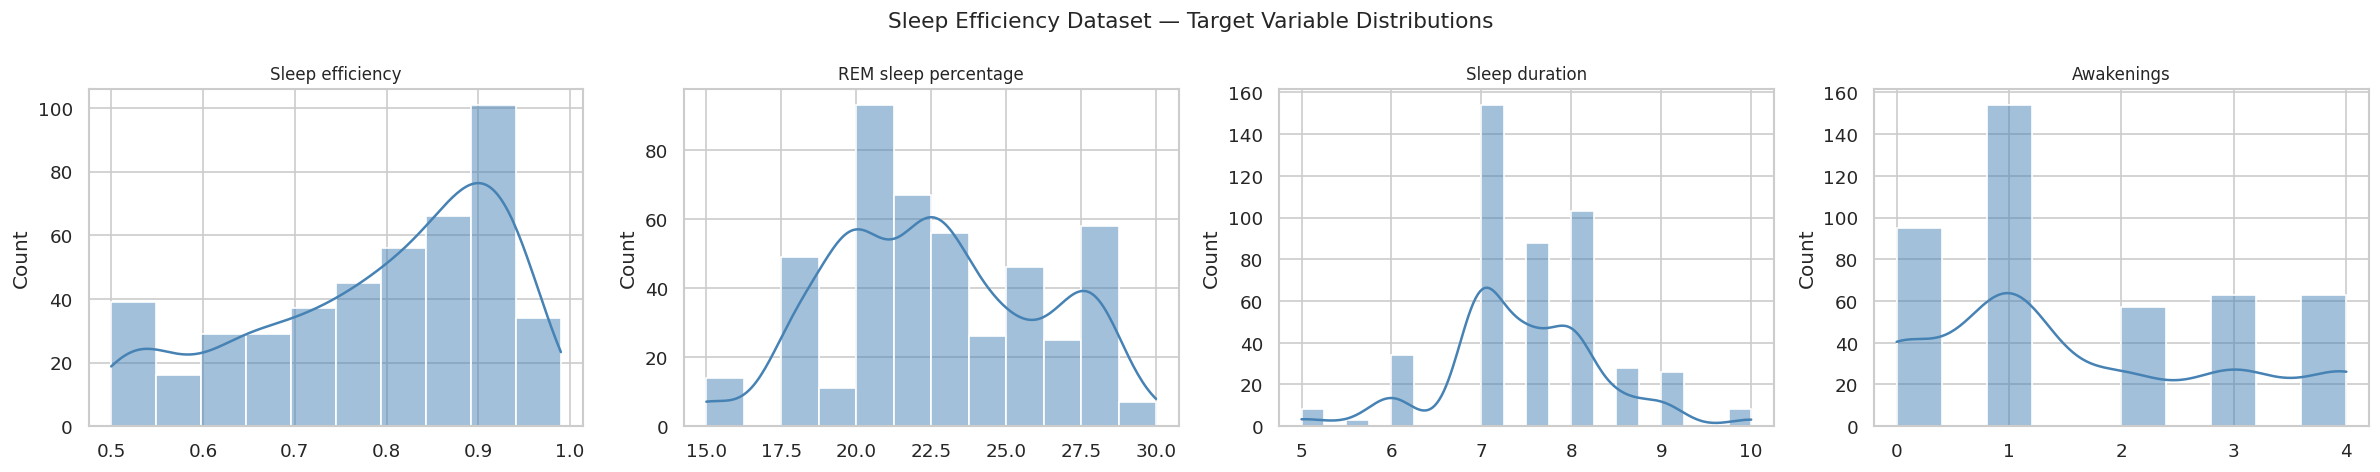

In [4]:
target_candidates = [
    'Sleep efficiency', 'REM sleep percentage',
    'Sleep duration', 'Awakenings'
]
targets = [c for c in target_candidates if c in df_sleep.columns]
print(f'Target columns present: {targets}')

fig, axes = plt.subplots(1, len(targets), figsize=(5 * len(targets), 4))
if len(targets) == 1:
    axes = [axes]

for ax, col in zip(axes, targets):
    sns.histplot(df_sleep[col].dropna(), kde=True, ax=ax, color='steelblue')
    ax.set_title(col, fontsize=10)
    ax.set_xlabel('')

fig.suptitle('Sleep Efficiency Dataset — Target Variable Distributions', fontsize=13)
plt.tight_layout()
plt.show()

### 2.2 Full Correlation Matrix

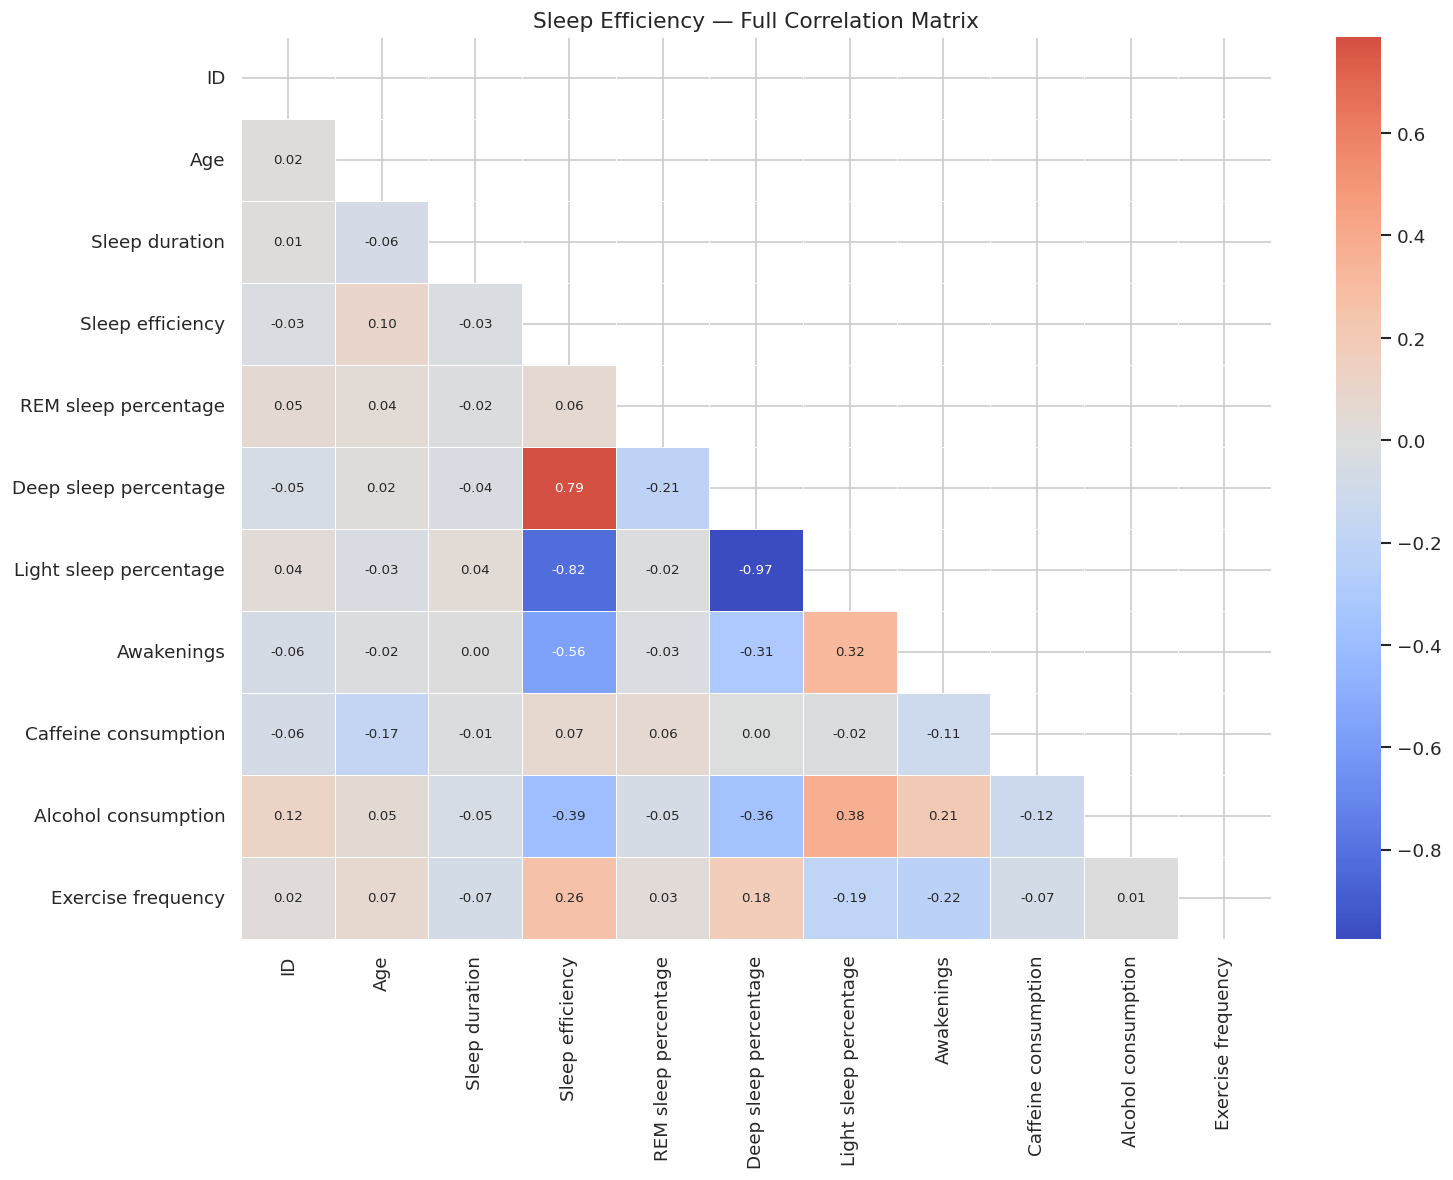

In [5]:
numeric_df = df_sleep.select_dtypes(include='number')
corr       = numeric_df.corr()

fig, ax = plt.subplots(figsize=(13, 10))
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(
    corr, mask=mask, annot=True, fmt='.2f',
    cmap='coolwarm', center=0, linewidths=0.5,
    annot_kws={'size': 8}, ax=ax
)
ax.set_title('Sleep Efficiency — Full Correlation Matrix', fontsize=13)
plt.tight_layout()
plt.show()

---
## 3. Feature Engineering <a id='section-3'></a>
`SleepQualityModel` exposes two internal preprocessing steps:
- `_encode_categoricals()` — label-encodes string columns (Gender, Smoking status)
- `_engineer_proxy_features()` — creates derived features such as `sleep_debt`, `efficiency_x_duration`, and interaction terms

We inspect the transformed dataframe before training.

In [6]:
model = SleepQualityModel()

df_encoded = _encode_categoricals(df_sleep.copy())
print('Columns after categorical encoding:')
print(df_encoded.dtypes)

Columns after categorical encoding:
Age                         int64
Gender                      int64
Sleep duration            float64
Sleep efficiency          float64
REM sleep percentage        int64
Deep sleep percentage       int64
Light sleep percentage      int64
Awakenings                float64
Caffeine consumption      float64
Alcohol consumption       float64
Smoking status              int64
Exercise frequency        float64
Season                        str
dtype: object


In [7]:
df_engineered = _engineer_proxy_features(df_encoded.copy())
new_cols = [c for c in df_engineered.columns if c not in df_encoded.columns]
print(f'New engineered features ({len(new_cols)}): {new_cols}')
df_engineered[new_cols].describe().T

New engineered features (7): ['arousal_index', 'fragmentation_proxy', 'fitness_proxy', 'age_numeric', 'age_young', 'age_middle', 'age_senior']


,count,mean,std,min,25%,50%,75%,max
arousal_index,452.0,0.282080,0.280944,0.0,0.0,0.250000,0.500000,1.000000
fragmentation_proxy,452.0,0.227434,0.321788,0.0,0.0,0.000000,0.400000,1.000000
fitness_proxy,452.0,0.258217,0.203621,0.0,0.0,0.285714,0.428571,0.714286
age_numeric,452.0,40.285398,13.172250,9.0,29.0,40.000000,52.000000,69.000000
age_young,452.0,0.367257,0.482591,0.0,0.0,0.000000,1.000000,1.000000
age_middle,452.0,0.557522,0.497231,0.0,0.0,1.000000,1.000000,1.000000
age_senior,452.0,0.075221,0.264040,0.0,0.0,0.000000,0.000000,1.000000


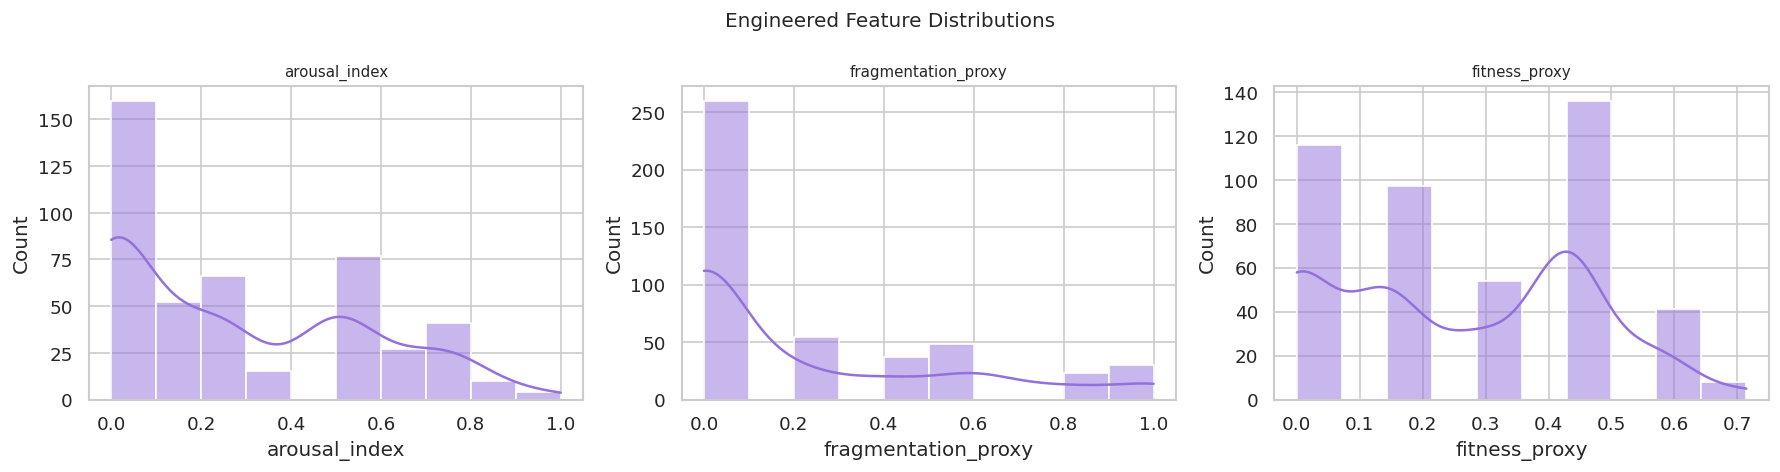

In [8]:
if new_cols:
    fig, axes = plt.subplots(1, min(3, len(new_cols)),
                             figsize=(5 * min(3, len(new_cols)), 4))
    if not hasattr(axes, '__len__'):
        axes = [axes]
    for ax, col in zip(axes, new_cols[:3]):
        sns.histplot(df_engineered[col].dropna(), kde=True, ax=ax, color='mediumpurple')
        ax.set_title(col, fontsize=9)
    plt.suptitle('Engineered Feature Distributions', fontsize=12)
    plt.tight_layout()
    plt.show()

---
## 4. Model Training & Cross-validation <a id='section-4'></a>
`SleepQualityModel.train()` fits a separate gradient-boosted regressor for each target variable.  
We use 5-fold CV to estimate generalisation performance (negative MAE and R²).

In [9]:
print('Training SleepQualityModel...')
model.train(df_sleep)
print('Training complete.')
print(f'Trained targets : {list(model.models.keys())}')

Training SleepQualityModel...


  [Sleep efficiency] CV RMSE = 0.0696, CV R² = 0.7321


  [Awakenings] CV RMSE = 1.3414, CV R² = 0.0075


  [REM sleep percentage] CV RMSE = 3.0254, CV R² = 0.2541


  [Deep sleep percentage] CV RMSE = 3.0055, CV R² = 0.9616


Training complete.
Trained targets : ['Sleep efficiency', 'Awakenings', 'REM sleep percentage', 'Deep sleep percentage']


=== 5-Fold Cross-Validation Results ===
                       RMSE (CV)  R² (CV)
Sleep efficiency          0.0696   0.7321
Awakenings                1.3414   0.0075
REM sleep percentage      3.0254   0.2541
Deep sleep percentage     3.0055   0.9616


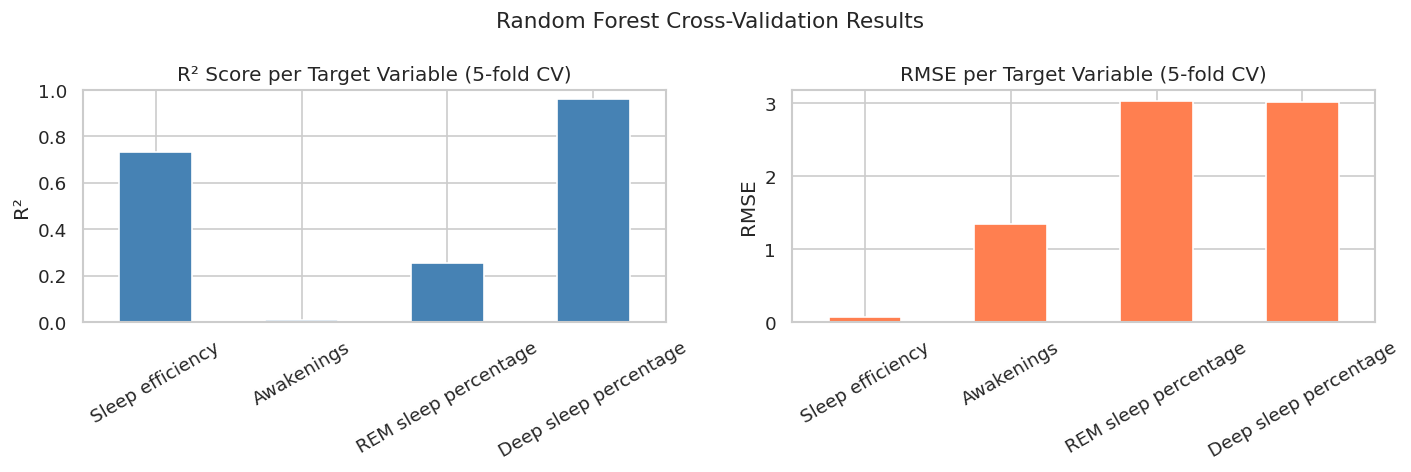

In [10]:
# Cross-validation using the model's built-in train() CV scores
# Re-run train() to capture CV results dictionary
cv_dict = model.train(df_sleep, cv_folds=5, verbose=False)

# Display as a styled table
cv_df = pd.DataFrame(cv_dict).T
cv_df.columns = ['RMSE (CV)', 'R² (CV)']
cv_df = cv_df.round(4)
print('=== 5-Fold Cross-Validation Results ===')
print(cv_df.to_string())

# Bar chart of R² scores
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
cv_df['R² (CV)'].plot.bar(ax=axes[0], color='steelblue', edgecolor='white')
axes[0].set_title('R² Score per Target Variable (5-fold CV)')
axes[0].set_ylabel('R²')
axes[0].set_ylim(0, 1)
axes[0].tick_params(axis='x', rotation=30)

cv_df['RMSE (CV)'].plot.bar(ax=axes[1], color='coral', edgecolor='white')
axes[1].set_title('RMSE per Target Variable (5-fold CV)')
axes[1].set_ylabel('RMSE')
axes[1].tick_params(axis='x', rotation=30)

plt.suptitle('Random Forest Cross-Validation Results', fontsize=13)
plt.tight_layout()
plt.show()

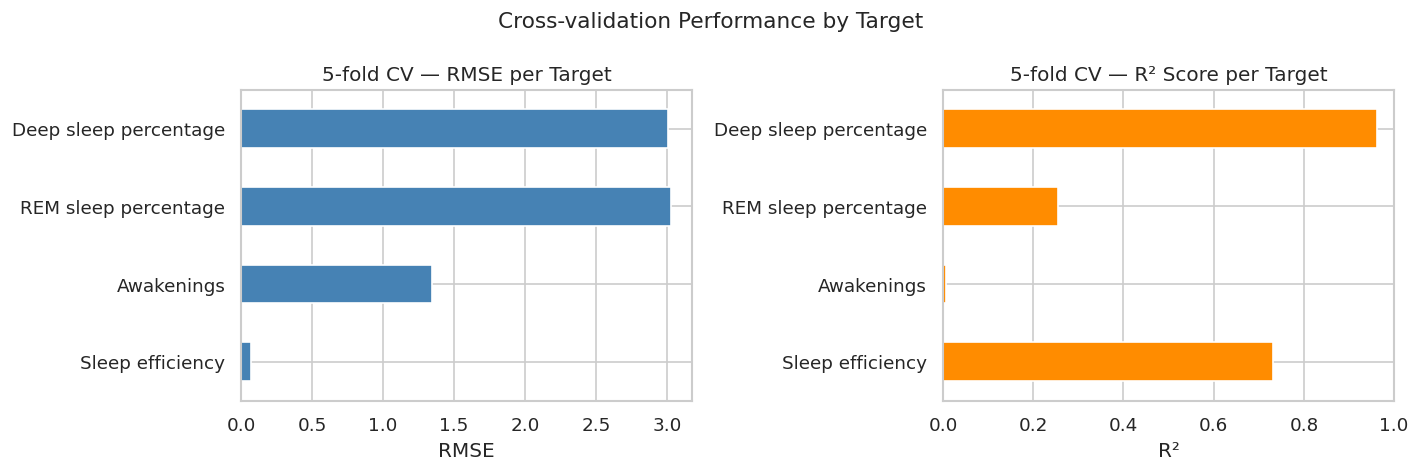

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

cv_df['RMSE (CV)'].plot(kind='barh', ax=ax1, color='steelblue')
ax1.set_title('5-fold CV — RMSE per Target')
ax1.set_xlabel('RMSE')

cv_df['R² (CV)'].plot(kind='barh', ax=ax2, color='darkorange')
ax2.set_title('5-fold CV — R² Score per Target')
ax2.set_xlabel('R²')
ax2.set_xlim(0, 1)

plt.suptitle('Cross-validation Performance by Target', fontsize=13)
plt.tight_layout()
plt.show()

---
## 5. Feature Importance Plots <a id='section-5'></a>
Each gradient-boosted regressor exposes `feature_importances_`. We plot the top-15 features for every target to understand which environmental and behavioural variables drive each outcome.

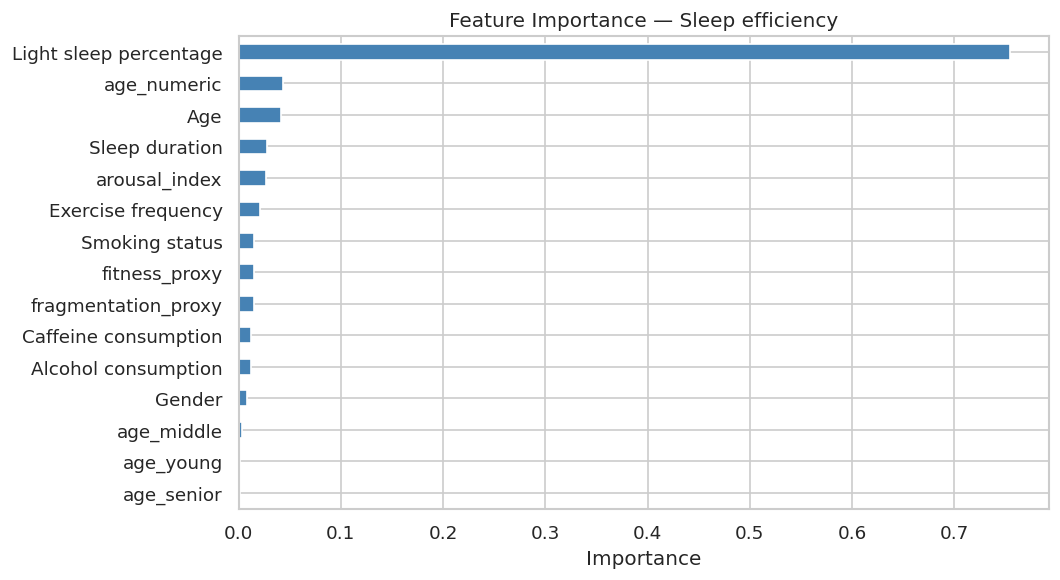

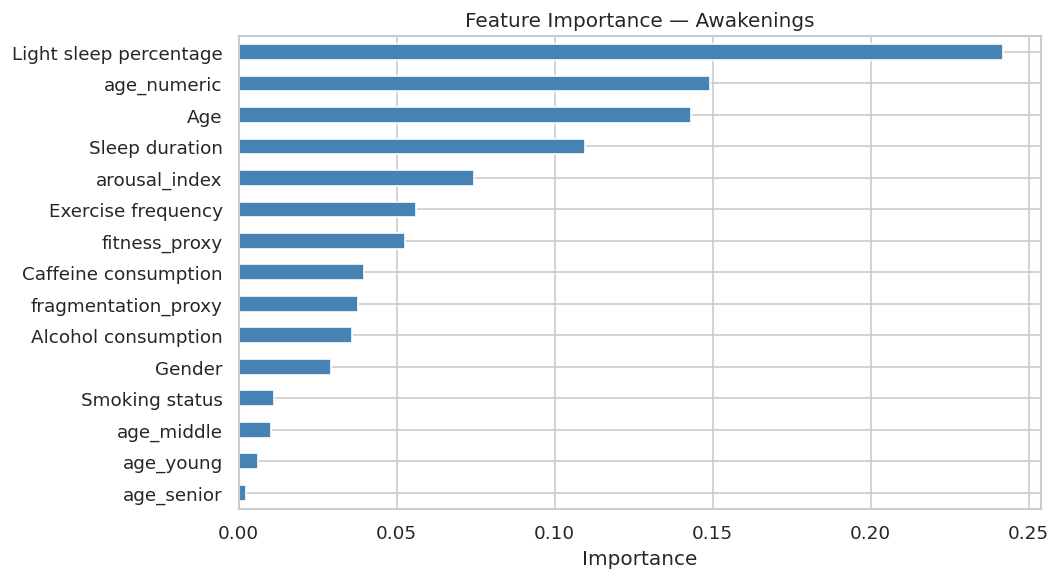

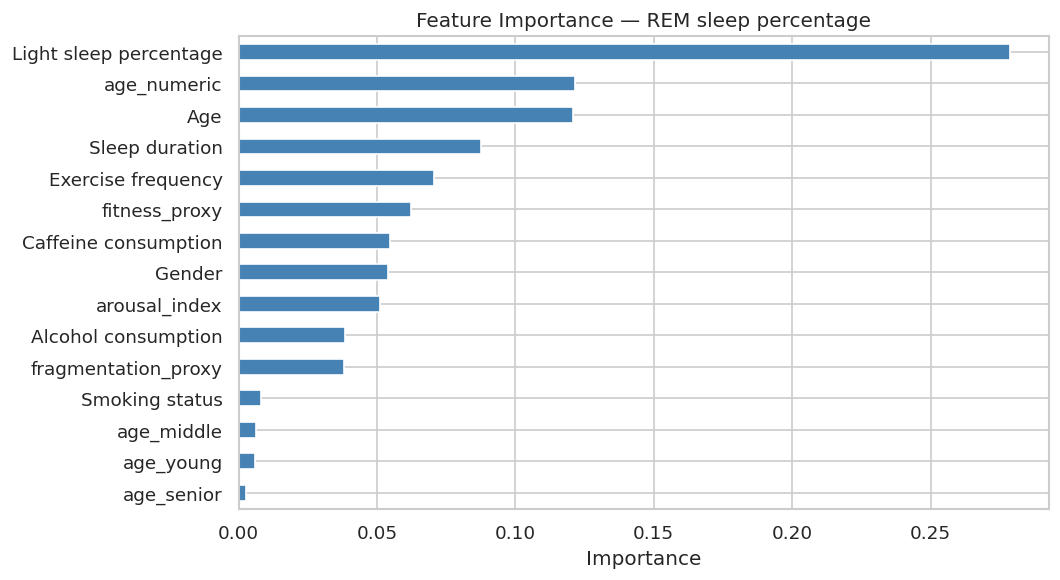

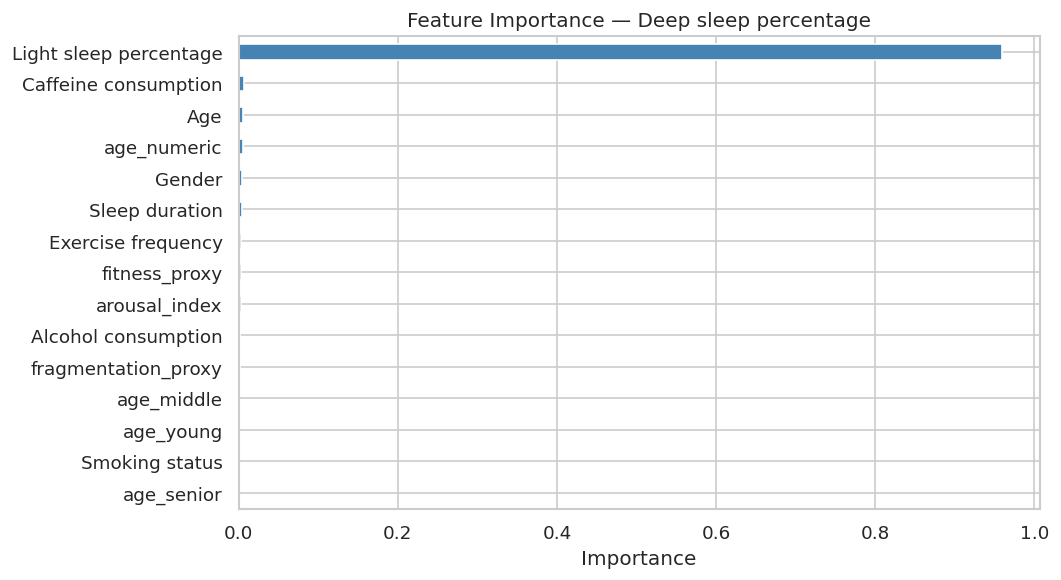

In [12]:
# Use model.feature_names (the exact columns used during training) as index
for target, estimator in model.models.items():
    if not hasattr(estimator, 'feature_importances_'):
        print(f'Skipping {target} — no feature_importances_')
        continue

    importances = estimator.feature_importances_
    fi_series   = pd.Series(importances, index=model.feature_names).sort_values(ascending=False)
    top_n       = fi_series.head(15)

    fig, ax = plt.subplots(figsize=(9, 5))
    top_n.plot.barh(ax=ax, color='steelblue')
    ax.invert_yaxis()
    ax.set_xlabel('Importance')
    ax.set_title(f'Feature Importance — {target}')
    plt.tight_layout()
    plt.show()

---
## 6. Residual Analysis <a id='section-6'></a>
Scatter plots of **predicted vs. actual** values (in-sample) and **residuals vs. predicted** help detect systematic bias or heteroscedasticity.

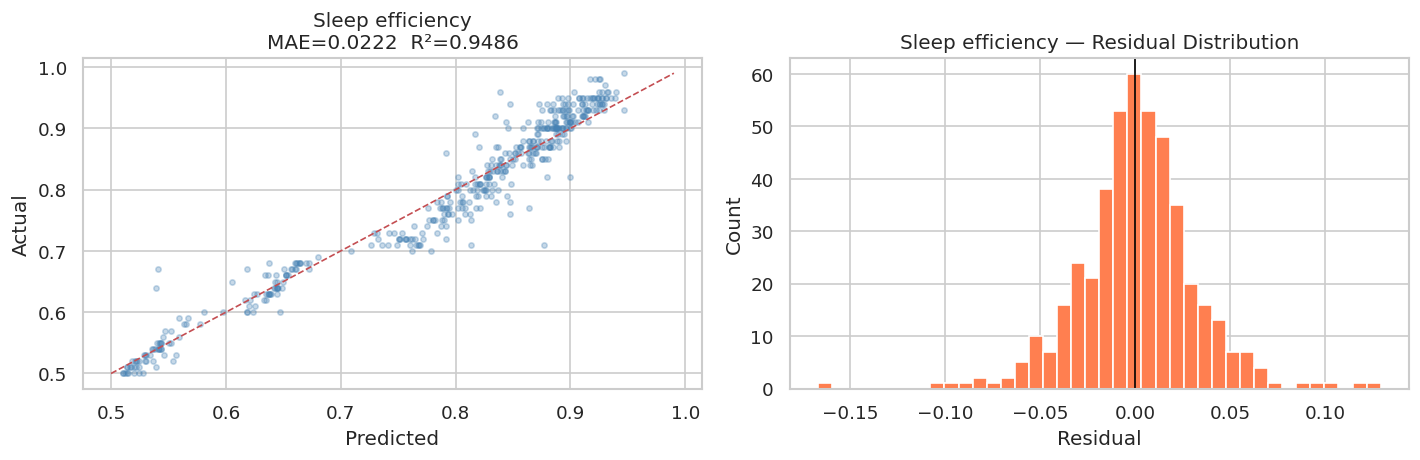

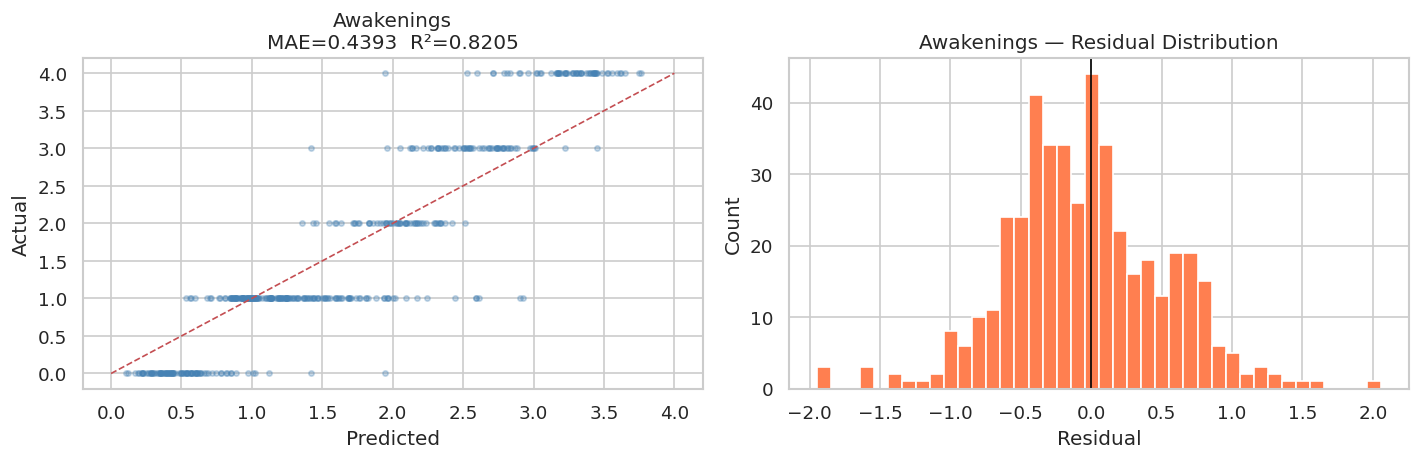

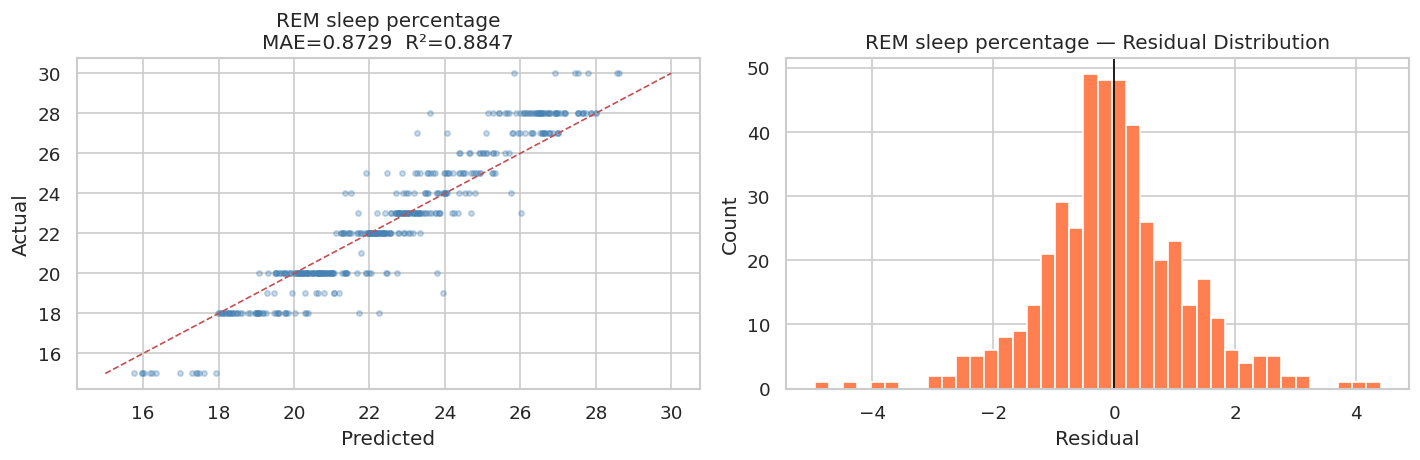

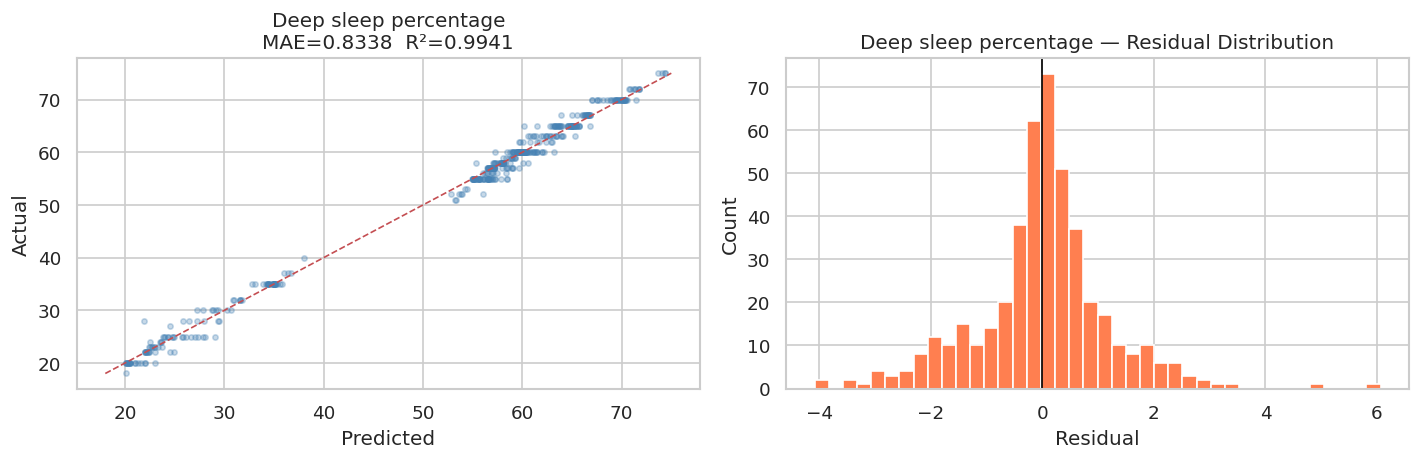

In [13]:
# Residual analysis using model.feature_names to align columns
df_res = _engineer_proxy_features(_encode_categoricals(df_sleep.copy()))
# Fill NaNs in all numeric columns
for c in df_res.select_dtypes(include='number').columns:
    df_res[c] = df_res[c].fillna(df_res[c].median())

for target, estimator in model.models.items():
    if target not in df_res.columns:
        continue
    # Use only the exact feature columns seen during training
    avail_feats = [f for f in model.feature_names if f in df_res.columns]
    X_res = df_res[avail_feats].fillna(0)
    y_res = df_res[target]

    y_pred    = estimator.predict(X_res)
    residuals = y_res.values - y_pred

    in_mae = mean_absolute_error(y_res, y_pred)
    in_r2  = r2_score(y_res, y_pred)

    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    axes[0].scatter(y_pred, y_res, alpha=0.3, s=10, color='steelblue')
    mn, mx = y_res.min(), y_res.max()
    axes[0].plot([mn, mx], [mn, mx], 'r--', linewidth=1)
    axes[0].set_xlabel('Predicted')
    axes[0].set_ylabel('Actual')
    axes[0].set_title(f'{target}\nMAE={in_mae:.4f}  R²={in_r2:.4f}')

    axes[1].hist(residuals, bins=40, color='coral', edgecolor='white')
    axes[1].axvline(0, color='black', linewidth=1)
    axes[1].set_xlabel('Residual')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'{target} — Residual Distribution')

    plt.tight_layout()
    plt.show()

### 6.1 Residual Histograms
Ideally the residuals should be approximately Gaussian — a significant skew signals systematic under- or over-prediction.

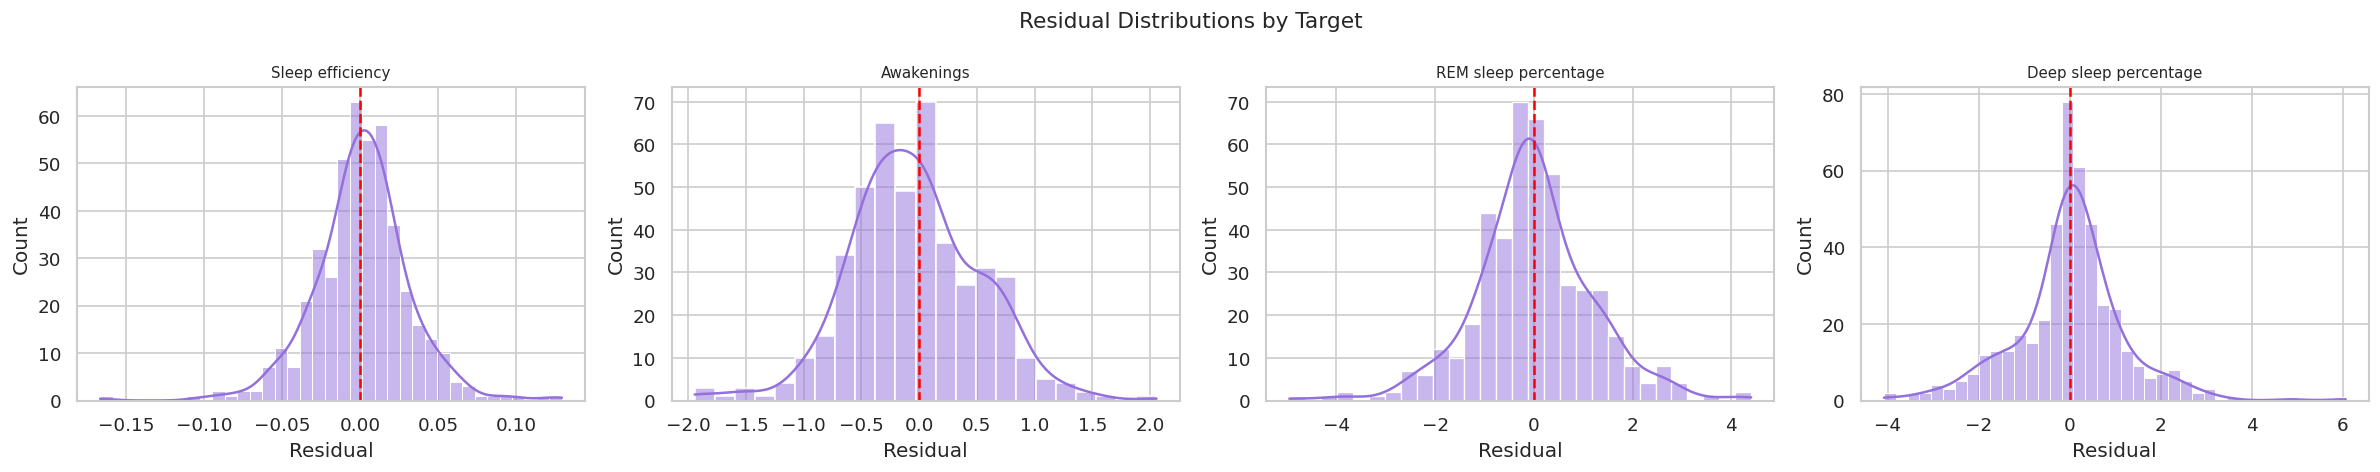

In [14]:
n_targets = len(model.models)
fig, axes = plt.subplots(1, n_targets, figsize=(5 * n_targets, 4))
if n_targets == 1:
    axes = [axes]

for ax, (target, estimator) in zip(axes, model.models.items()):
    X_r = df_res[model.feature_names].fillna(0)
    y_r = df_res[target].fillna(df_res[target].median())
    res = y_r.values - estimator.predict(X_r)

    sns.histplot(res, kde=True, ax=ax, color='mediumpurple')
    ax.axvline(0, color='red', linestyle='--')
    ax.set_title(target, fontsize=9)
    ax.set_xlabel('Residual')

fig.suptitle('Residual Distributions by Target', fontsize=13)
plt.tight_layout()
plt.show()

---
## 7. Save Models <a id='section-7'></a>
Persist each trained estimator to the `models/` directory using **joblib** so they can be loaded by the generation pipeline without re-training.

In [15]:
for target, estimator in model.models.items():
    safe_name  = target.lower().replace(' ', '_').replace('%', 'pct')
    save_path  = os.path.join(MODELS_DIR, f'{safe_name}_regressor.joblib')
    joblib.dump(estimator, save_path)
    print(f'Saved: {save_path}')

Saved: /home/rushav/TECHIN516Final/sleep_dataset_generator/data/processed/models/sleep_efficiency_regressor.joblib
Saved: /home/rushav/TECHIN516Final/sleep_dataset_generator/data/processed/models/awakenings_regressor.joblib
Saved: /home/rushav/TECHIN516Final/sleep_dataset_generator/data/processed/models/rem_sleep_percentage_regressor.joblib
Saved: /home/rushav/TECHIN516Final/sleep_dataset_generator/data/processed/models/deep_sleep_percentage_regressor.joblib


In [16]:
# Optionally save the full SleepQualityModel object
full_model_path = os.path.join(MODELS_DIR, 'sleep_quality_model.joblib')
joblib.dump(model, full_model_path)
print(f'Full model saved: {full_model_path}')

Full model saved: /home/rushav/TECHIN516Final/sleep_dataset_generator/data/processed/models/sleep_quality_model.joblib


In [17]:
# Verify that saved models can be reloaded correctly
loaded_model = joblib.load(full_model_path)
print(f'Loaded model type  : {type(loaded_model)}')
print(f'Loaded model targets: {list(loaded_model.models.keys())}')
print('\nNotebook 03 complete.')

Loaded model type  : <class 'src.sleep_quality_model.SleepQualityModel'>
Loaded model targets: ['Sleep efficiency', 'Awakenings', 'REM sleep percentage', 'Deep sleep percentage']

Notebook 03 complete.
